In [6]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
ip = "192.168.4.203"
duckdb.sql("INSTALL postgres;")
duckdb.sql("LOAD postgres;")
duckdb.sql(f"ATTACH 'dbname=postgres user=postgres host={ip} password=template!PWD' AS db (TYPE POSTGRES);")


AMD Ryzen 5 5600G 4.46GHz

Intel N100 

Text(0.5, 1.0, 'Time vs Generation')

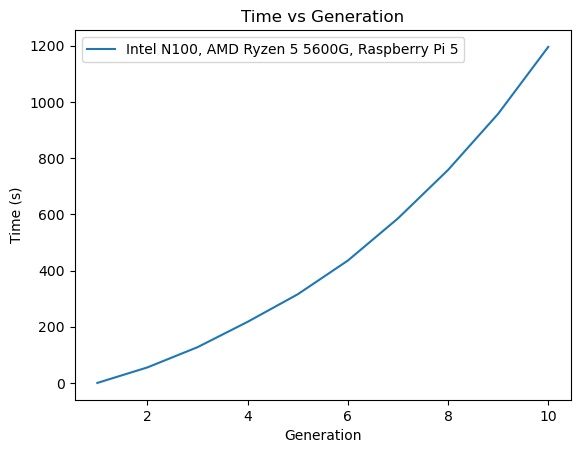

In [92]:
df = duckdb.query("""
SELECT * FROM db.public.time_monitor
""").df()

df["time_elapsed"] = df['time'] - df['time'].min()

plt.plot(df['generation'], df['time_elapsed'], label="Intel N100, AMD Ryzen 5 5600G, Raspberry Pi 5")
plt.ylabel("Time (s)")
plt.xlabel("Generation")
plt.legend()
plt.title("Time vs Generation")


Text(0.5, 0, 'Generation')

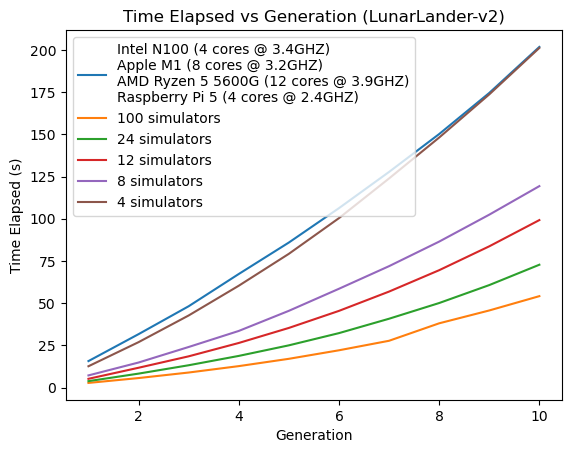

In [82]:
df_100 = pd.read_csv("lunar_lander_100_envs.csv")
df_24 = pd.read_csv("lunar_lander_24_envs.csv")
df_12 = pd.read_csv("lunar_lander_12_envs.csv")
df_8 = pd.read_csv("lunar_lander_8_envs.csv")
df_4 = pd.read_csv("lunar_lander_4_envs.csv")
df_all = pd.read_csv("lunar_lander_all_hosts.csv")
plt.plot(df_all['generation'], df_all['time_elapsed'], label='Intel N100 (4 cores @ 3.4GHZ)\nApple M1 (8 cores @ 3.2GHZ)\nAMD Ryzen 5 5600G (12 cores @ 3.9GHZ)\nRaspberry Pi 5 (4 cores @ 2.4GHZ)')
plt.plot(df_100['generation'], df_100['time_elapsed'], label='100 simulators')
plt.plot(df_24['generation'], df_24['time_elapsed'], label='24 simulators')
plt.plot(df_12['generation'], df_12['time_elapsed'], label='12 simulators')
plt.plot(df_8['generation'], df_8['time_elapsed'], label='8 simulators')
plt.plot(df_4['generation'], df_4['time_elapsed'], label='4 simulators')
plt.legend()
plt.title("Time Elapsed vs Generation (LunarLander-v2)")
plt.ylabel("Time Elapsed (s)")
plt.xlabel("Generation")

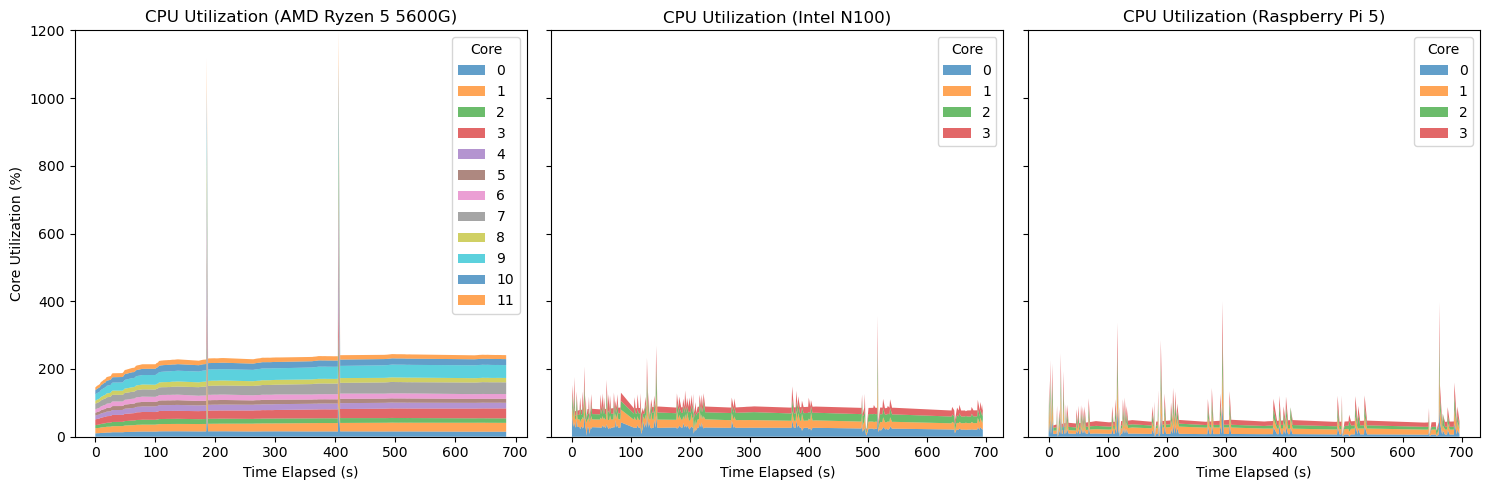

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import duckdb

# Define the workers you want to plot
workers = ['desktop', 'beelink', 'raspberrypi']

# Set up the figure and axes for subplots
fig, axes = plt.subplots(nrows=1, ncols=len(workers), figsize=(15, 5), sharey=True)

# Plotting for each worker
for i, worker in enumerate(workers):
    # Query and prepare the data
    df = duckdb.query(f"""
    SELECT * FROM db.public.cpu_utilization
    WHERE worker = '{worker}'
    """).df()

    # Calculate time elapsed
    df['time_elapsed'] = df['time'] - df['time'].min()

    # Pivot the DataFrame for plotting
    pivot_df = df.pivot_table(index='time_elapsed', columns='core', values='utilization', aggfunc='mean')

    # Plotting
    axes[i].stackplot(pivot_df.index, pivot_df.T, labels=pivot_df.columns, alpha=0.7)
    axes[i].set_xlabel('Time Elapsed (s)')

    if worker == "desktop":
        axes[i].set_title(f'CPU Utilization (AMD Ryzen 5 5600G)')
    elif worker == "beelink":
        axes[i].set_title(f'CPU Utilization (Intel N100)')
    elif worker == "raspberrypi":
        axes[i].set_title(f'CPU Utilization (Raspberry Pi 5)')
    elif worker == "macbook":
        axes[i].set_title(f"CPU Utilization (Apple M1)")
        
    axes[i].set_ylim(0, 1200)
    
    if i == 0:
        axes[i].set_ylabel('Core Utilization (%)')
    
    axes[i].legend(title='Core')

# Adjust layout
plt.tight_layout()
plt.show()


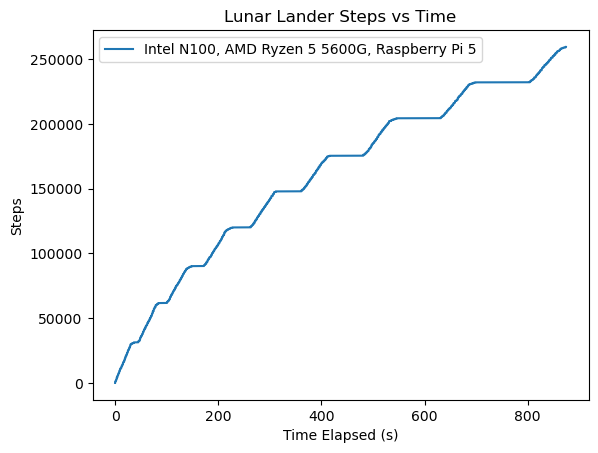

In [88]:
df = duckdb.query("""
SELECT time, COUNT(*) OVER (ORDER BY time ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) as num_steps
FROM db.public.training
ORDER BY time
""").df()

df['elapsed_time'] = df['time'] - df['time'].min()

plt.plot(df['elapsed_time'], df['num_steps'], label='Intel N100, AMD Ryzen 5 5600G, Raspberry Pi 5')

plt.ylabel('Steps')
plt.xlabel('Time Elapsed (s)')
plt.title("Lunar Lander Steps vs Time")
plt.legend()

   generation  min_cumulative_reward  avg_cumulative_reward  \
0           1           -4728.820660            -467.330161   
1           2           -5736.016350            -396.701262   
5           3           -2400.748052            -329.378665   
6           4           -6568.027316            -397.452693   
2           5           -2625.591771            -309.000146   
3           6           -2331.044951            -316.417303   
4           7           -3873.060262            -335.944095   

   max_cumulative_reward          time  time_elapsed  
0              17.865805  1.722289e+09      0.000000  
1              31.679821  1.722289e+09     55.191636  
5              66.256088  1.722289e+09    127.167753  
6              42.304840  1.722289e+09    217.425059  
2              15.654796  1.722289e+09    315.405664  
3              57.202722  1.722290e+09    435.322039  
4              31.236527  1.722290e+09    585.363485  


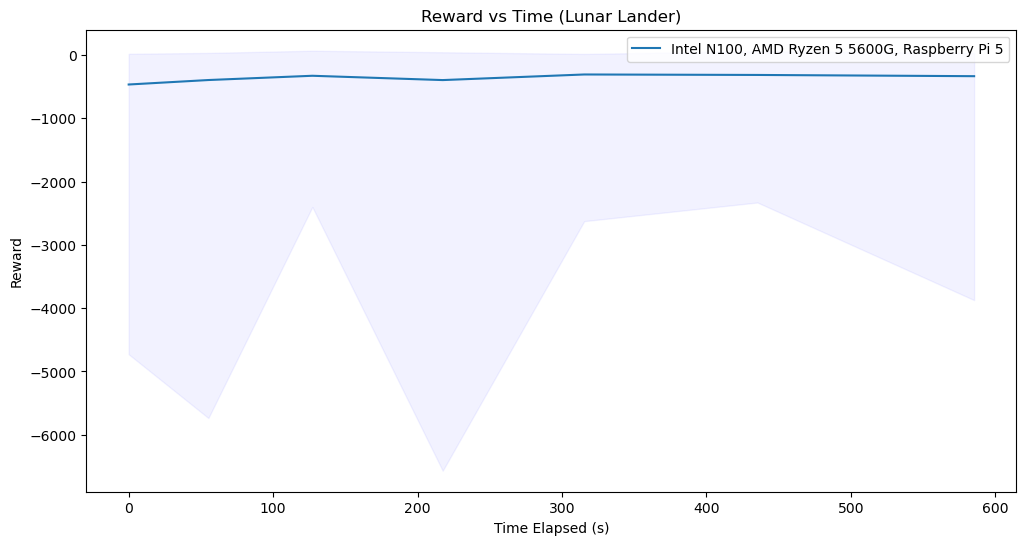

In [86]:
import matplotlib.pyplot as plt
import duckdb

# Query to get the data
df = duckdb.query("""
WITH 
cumulative_reward AS
(
    SELECT generation, SUM(reward) AS cumulative_reward
    FROM db.public.training
    GROUP BY generation, team_id
), 
reward_by_generation AS
(
    SELECT generation,
           MIN(cumulative_reward) AS min_cumulative_reward, 
           AVG(cumulative_reward) AS avg_cumulative_reward, 
           MAX(cumulative_reward) AS max_cumulative_reward
    FROM cumulative_reward
    JOIN db.public.time_monitor USING (generation)
    GROUP BY generation
    ORDER BY generation
)
SELECT * FROM reward_by_generation
JOIN db.public.time_monitor USING (generation)
""").df()

df['time_elapsed'] = df['time'] - df['time'].min()

df.sort_values(by=['time_elapsed'], inplace=True)
print(df)

# Plotting the data
plt.figure(figsize=(12, 6))  # Set figure size

# Plot shaded area for min and max
plt.fill_between(df['time_elapsed'], 
                 df['min_cumulative_reward'], 
                 df['max_cumulative_reward'], 
                 color='blue', alpha=0.05)

# Plot Average Cumulative Reward by Time
plt.plot(df['time_elapsed'], df['avg_cumulative_reward'], label="Intel N100, AMD Ryzen 5 5600G, Raspberry Pi 5")

# Add labels and title
plt.ylabel('Reward')
plt.xlabel('Time Elapsed (s)')
plt.title("Reward vs Time (Lunar Lander)")

plt.legend()
